## Import Semua Packages/Library yang Digunakan

In [ ]:
!pip install ImageHash

import os
import glob
import shutil
import random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import imagehash
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import files
import tensorflow as tf
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2

## Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path ke folder dataset
base_dir = '/content/drive/MyDrive/dataset PI'

# Tampilkan isi folder
print(os.listdir(base_dir))

['naturalisme', 'realisme']


### Plot gambar sampel untuk semua kelas

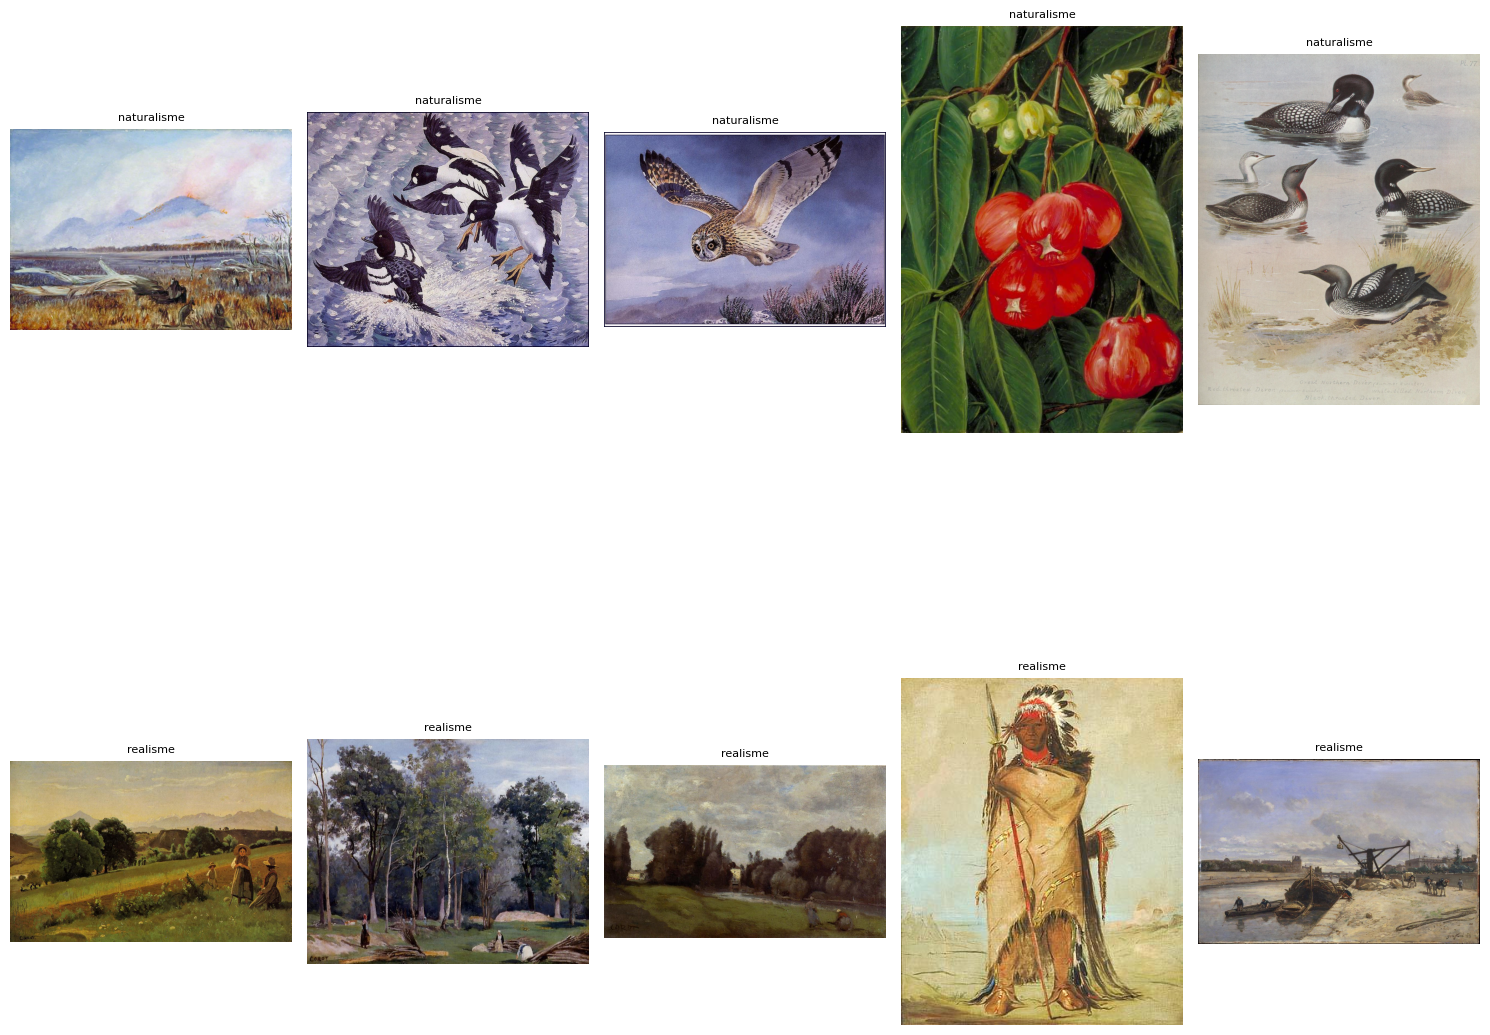

In [ ]:
# Simpan daftar gambar per kelas
painting_images = {}

for class_name in os.listdir(base_dir):
    painting_images[class_name] = os.listdir(os.path.join(base_dir, class_name))

# Tampilkan 5 gambar acak dari tiap kelas
fig, axs = plt.subplots(len(painting_images.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(base_dir)):
    images = np.random.choice(painting_images[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(base_dir, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set_title(class_name, fontsize=8)
        axs[i, j].axis('off')

fig.tight_layout()
plt.show()

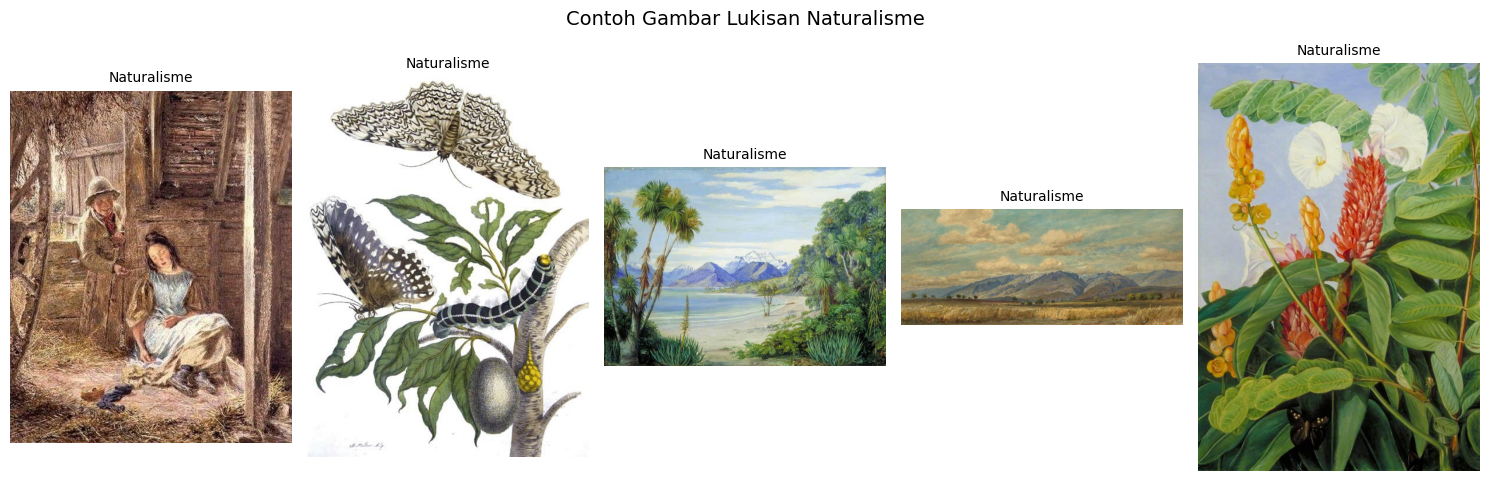

In [ ]:
# Tampilkan 5 gambar acak dari kelas Naturalisme
naturalisme_path = os.path.join(base_dir, 'naturalisme')

if os.path.exists(naturalisme_path):
    image_files = os.listdir(naturalisme_path)
    selected_images = random.sample(image_files, min(5, len(image_files)))

    plt.figure(figsize=(15, 5))
    for i, image_name in enumerate(selected_images):
        img_path = os.path.join(naturalisme_path, image_name)
        img = Image.open(img_path)
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title("Naturalisme", fontsize=10)
    plt.suptitle("Contoh Gambar Lukisan Naturalisme", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("Folder Naturalisme tidak ditemukan.")

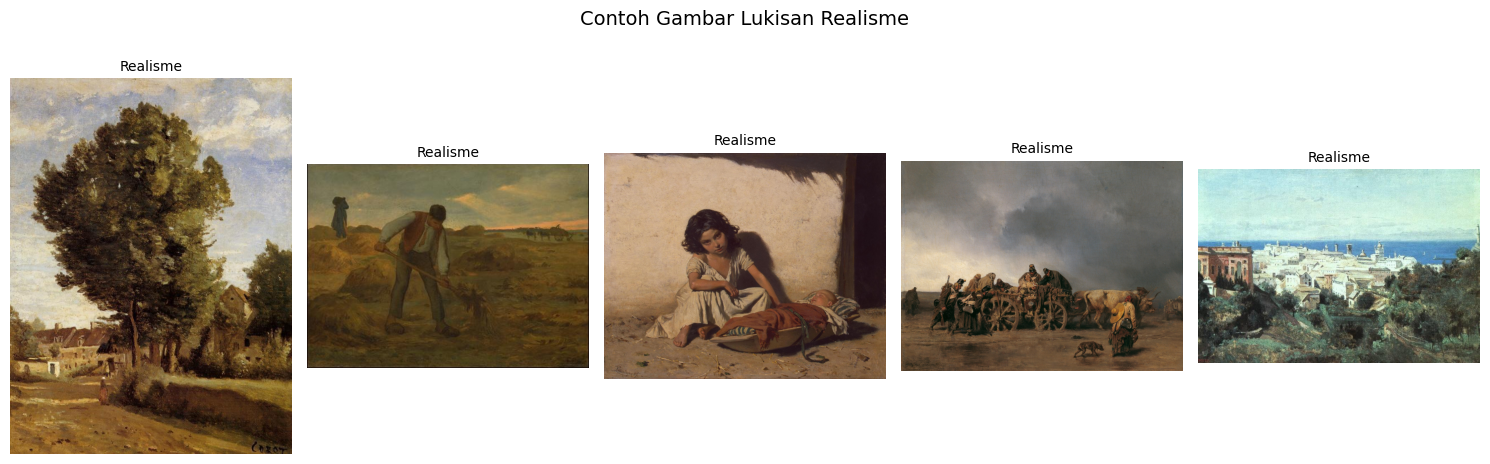

In [ ]:
# Tampilkan 5 gambar acak dari kelas Realisme
realisme_path = os.path.join(base_dir, 'realisme')

if os.path.exists(realisme_path):
    image_files = os.listdir(realisme_path)
    selected_images = random.sample(image_files, min(5, len(image_files)))

    plt.figure(figsize=(15, 5))
    for i, image_name in enumerate(selected_images):
        img_path = os.path.join(realisme_path, image_name)
        img = Image.open(img_path)
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title("Realisme", fontsize=10)
    plt.suptitle("Contoh Gambar Lukisan Realisme", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("Folder Realisme tidak ditemukan.")

### Plot distribusi gambar di seluruh kelas

labels
realisme       799
naturalisme    653
Name: count, dtype: int64


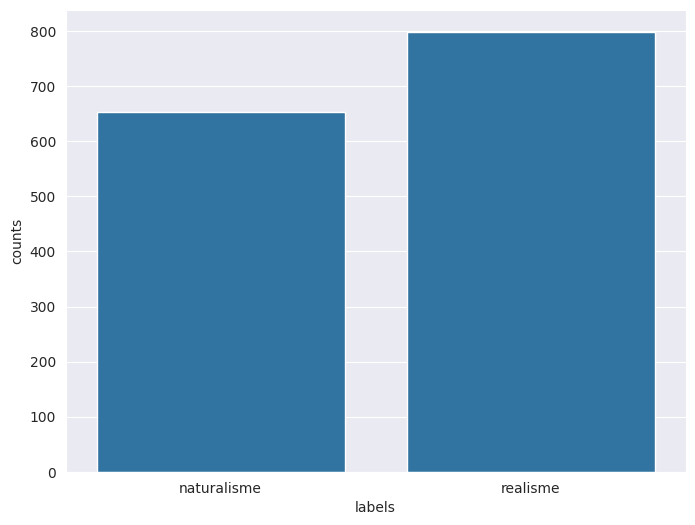

In [ ]:
# Membuat list untuk menyimpan nama file, label, dan path gambar
file_name = []
labels = []
full_path = []

# Telusuri semua gambar dalam dataset
for path, subdirs, files in os.walk(base_dir):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])  # Ambil nama folder sebagai label
        file_name.append(name)

# Membuat DataFrame untuk distribusi gambar
distribution_train = pd.DataFrame({"path": full_path, "file_name": file_name, "labels": labels})

# Tampilkan jumlah gambar per kelas
print(distribution_train['labels'].value_counts())

# Plot distribusi gambar
Label = distribution_train['labels']
plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
plot_data = sns.countplot(x=Label)
plot_data.set_xlabel('labels')
plot_data.set_ylabel('counts')
plt.show()

In [ ]:
# Cek kualitas gambar

# Ukuran minimal gambar
min_width = 100
min_height = 100

# Inisialisasi statistik
corrupt_count = 0
duplicate_count = 0
small_image_count = 0
total_checked = 0
hashes = {}

# Simpan path gambar bermasalah
corrupt_files = []
duplicate_files = []
small_files = []

# Periksa semua gambar
for label in os.listdir(base_dir):
    class_path = os.path.join(base_dir, label)
    if not os.path.isdir(class_path):
        continue

    for file in os.listdir(class_path):
        file_path = os.path.join(class_path, file)
        total_checked += 1

        try:
            with Image.open(file_path) as img:
                img.verify()

            with Image.open(file_path) as img:
                img = img.convert('RGB')

                # Cek ukuran gambar
                if img.width < min_width or img.height < min_height:
                    small_image_count += 1
                    small_files.append(file_path)
                    continue

                # Cek duplikat
                img_hash = str(imagehash.phash(img))
                if img_hash in hashes:
                    duplicate_count += 1
                    duplicate_files.append(file_path)
                else:
                    hashes[img_hash] = file_path

        except Exception:
            corrupt_count += 1
            corrupt_files.append(file_path)

# Ringkasan hasil pengecekan
print("Ringkasan Pengecekan Dataset:")
print(f"Total gambar diperiksa    : {total_checked}")
print(f"Gambar corrupt            : {corrupt_count}")
print(f"Gambar terlalu kecil      : {small_image_count}")
print(f"Gambar duplikat           : {duplicate_count}")
print(f"Total gambar bermasalah   : {corrupt_count + small_image_count + duplicate_count}")

Ringkasan Pengecekan Dataset:
Total gambar diperiksa    : 1452
Gambar corrupt            : 0
Gambar terlalu kecil      : 0
Gambar duplikat           : 2
Total gambar bermasalah   : 2


## Data Preparation

### Data Cleaning

In [ ]:
# Path folder awal dan folder bersih
raw_dir = '/content/drive/MyDrive/dataset PI baru'
clean_dir = '/content/cleaned_dataset'

# Hapus folder bersih jika sudah ada, lalu buat ulang
if os.path.exists(clean_dir):
    shutil.rmtree(clean_dir)
os.makedirs(clean_dir)

# Ukuran minimal gambar
min_width = 100
min_height = 100

# Inisialisasi statistik
corrupt_count = 0
small_image_count = 0
duplicate_count = 0
total_checked = 0
hashes = {}

# Proses semua gambar
for label in os.listdir(raw_dir):
    class_path = os.path.join(raw_dir, label)
    if not os.path.isdir(class_path):
        continue

    save_path = os.path.join(clean_dir, label)
    os.makedirs(save_path, exist_ok=True)

    for file in os.listdir(class_path):
        file_path = os.path.join(class_path, file)
        total_checked += 1

        try:
            # Cek gambar corrupt
            with Image.open(file_path) as img:
                img.verify()

            # Buka ulang dan convert ke RGB
            with Image.open(file_path) as img:
                img = img.convert('RGB')

                # Cek ukuran gambar
                if img.width < min_width or img.height < min_height:
                    small_image_count += 1
                    print(f"[Kecil] Hapus: {file_path}")
                    continue

                # Cek duplikat
                img_hash = str(imagehash.phash(img))
                if img_hash in hashes:
                    duplicate_count += 1
                    print(f"[Duplikat] Hapus: {file_path}")
                    continue
                else:
                    hashes[img_hash] = file_path

                # Salin gambar bersih ke folder baru
                shutil.copy(file_path, os.path.join(save_path, file))

        except Exception as e:
            corrupt_count += 1
            print(f"[Corrupt] Hapus: {file_path}")

# Ringkasan hasil cleaning
print("\nRingkasan Cleaning Dataset:")
print(f"Total dicek             : {total_checked}")
print(f"Corrupt dihapus         : {corrupt_count}")
print(f"Terlalu kecil dihapus   : {small_image_count}")
print(f"Duplikat dihapus        : {duplicate_count}")
print(f"Total dibersihkan       : {corrupt_count + small_image_count + duplicate_count}")

# Tampilkan jumlah total gambar bersih
total_clean = 0
print("\nJumlah gambar bersih per kelas:")

for label in os.listdir(clean_dir):
    label_path = os.path.join(clean_dir, label)
    num_images = len(glob.glob(os.path.join(label_path, '*')))
    total_clean += num_images
    print(f"- {label}: {num_images} gambar")

print(f"\n Total gambar bersih: {total_clean} gambar")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Duplikat] Hapus: /content/drive/MyDrive/dataset PI baru/naturalisme/Marianne_North_Ipomoea.jpg
[Duplikat] Hapus: /content/drive/MyDrive/dataset PI baru/naturalisme/John_James_Audubon_PURPLE_GRACKLE.jpg

 Ringkasan Cleaning Dataset:
Total dicek             : 1452
Corrupt dihapus         : 0
Terlalu kecil dihapus   : 0
Duplikat dihapus        : 2
Total dibersihkan       : 2

Jumlah gambar bersih per kelas:
- realisme: 799 gambar
- naturalisme: 651 gambar

 Total gambar bersih: 1450 gambar


In [ ]:
# Buat dataframe dari folder cleaned_dataset
paths, labels = [], []
for path, _, files in os.walk(clean_dir):
    for file in files:
        paths.append(os.path.join(path, file))
        labels.append(os.path.basename(path))

df = pd.DataFrame({'path': paths, 'label': labels})

# Tampilkan distribusi label
print("\nDistribusi label:")
print(df['label'].value_counts())


Distribusi label:
label
realisme       799
naturalisme    651
Name: count, dtype: int64


### Split Dataset

In [ ]:
# Memisahkan fitur dan label
X = df['path']
y = df['label']

# Membagi data menjadi train (80%) dan temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Membagi temp menjadi validation (10%) dan test (10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Mengecek jumlah data setiap set
print(f"Jumlah data train       : {len(X_train)}")
print(f"Jumlah data validation  : {len(X_val)}")
print(f"Jumlah data test        : {len(X_test)}")

Jumlah data train       : 1160
Jumlah data validation  : 145
Jumlah data test        : 145


In [ ]:
# Buat DataFrame untuk setiap set
df_train = pd.DataFrame({'path': X_train, 'label': y_train})
df_val = pd.DataFrame({'path': X_val, 'label': y_val})
df_test = pd.DataFrame({'path': X_test, 'label': y_test})

In [ ]:
# Menampilkan jumlah gambar per kelas di setiap set
for set_name, df_set in {'Training': df_train, 'Validation': df_val, 'Testing': df_test}.items():
    print(f"\nJumlah gambar pada {set_name} set:")
    for label in df_set['label'].unique():
        count = df_set[df_set['label'] == label].shape[0]
        print(f"Total gambar kelas {label}: {count}")


Jumlah gambar pada Training set:
Total gambar kelas realisme: 639
Total gambar kelas naturalisme: 521

Jumlah gambar pada Validation set:
Total gambar kelas realisme: 80
Total gambar kelas naturalisme: 65

Jumlah gambar pada Testing set:
Total gambar kelas naturalisme: 65
Total gambar kelas realisme: 80


### Preprocessing dan Data Augmentation

In [ ]:
# Ukuran gambar dan batch
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

# Augmentasi untuk data train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Data validation dan data test hanya rescale
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generator untuk data train
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=42
)

# Generator untuk data validation
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col='path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Generator untuk data test
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 1160 validated image filenames belonging to 2 classes.
Found 145 validated image filenames belonging to 2 classes.
Found 145 validated image filenames belonging to 2 classes.


In [ ]:
print(train_generator.class_indices)

{'naturalisme': 0, 'realisme': 1}


## Modeling

In [ ]:
# Membersihkan sesi sebelumnya
tf.keras.backend.clear_session()

# Inisialisasi MobileNetV2 sebagai feature extractor
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze semua layer base model
base_model.trainable = False

# Bangun model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Output sigmoid untuk binary classification
])

# Kompilasi model
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Ringkasan model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Callback
callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

# Training model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.6995 - loss: 0.5869

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 0.37429, saving model to best_model.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 52s 576ms/step - accuracy: 0.7003 - loss: 0.5859 - val_accuracy: 0.8276 - val_loss: 0.3743 - learning_rate: 5.0000e-04
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.8095 - loss: 0.4217
Epoch 2: val_loss did not improve from 0.37429
73/73 ━━━━━━━━━━━━━━━━━━━━ 32s 434ms/step - accuracy: 0.8096 - loss: 0.4216 - val_accuracy: 0.8069 - val_loss: 0.3830 - learning_rate: 5.0000e-04
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.8228 - loss: 0.3810
Epoch 3: val_loss improved from 0.37429 to 0.29442, saving model to best_model.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 33s 447ms/step - accuracy: 0.8228 - loss: 0.3811 - val_accuracy: 0.9034 - val_loss: 0.2944 - learning_rate: 5.0000e-04
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.8493 - loss: 0.3507
Epoch 4: val_loss improved from 0.29442 to 0.28635, saving model to best_model.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 32s 434ms/step - accuracy: 0.8491 - loss: 0.3508 - val_accuracy: 0.8966 - val_loss: 0.2863 - learning_rate: 5.0000e-04
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.8547 - loss: 0.3030
Epoch 5: val_loss did not improve from 0.28635
73/73 ━━━━━━━━━━━━━━━━━━━━ 31s 429ms/step - accuracy: 0.8545 - loss: 0.3035 - val_accuracy: 0.8483 - val_loss: 0.3355 - learning_rate: 5.0000e-04
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.8659 - loss: 0.3090
Epoch 6: val_loss did not improve from 0.28635
73/73 ━━━━━━━━━━━━━━━━━━━━ 34s 472ms/step - accuracy: 0.8657 - loss: 0.3093 - val_accuracy: 0.8966 - val_loss: 0.2906 - learning_rate: 5.0000e-04
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.8737 - loss: 0.2904
Epoch 7: val_loss did not improve from 0.28635

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
73/73 ━━━━━━━━━━━━━━━━━━━━ 31s 429ms/step - accuracy: 0.8738 - loss: 0.2903 - val_acc

## Evaluasi dan Visualisasi

In [ ]:
# Evaluasi pada data train
train_loss, train_acc = model.evaluate(
    train_generator,
    steps=len(train_generator),
    verbose=1
)
print(f"\n Evaluasi Training Set")
print(f" Akurasi : {train_acc * 100:.2f}%")
print(f" Loss    : {train_loss:.4f}")

# Evaluasi pada data test
test_loss, test_acc = model.evaluate(
    test_generator,
    steps=len(test_generator),
    verbose=1
)
print(f"\n Evaluasi Testing Set")
print(f" Akurasi : {test_acc * 100:.2f}%")
print(f" Loss    : {test_loss:.4f}")

73/73 ━━━━━━━━━━━━━━━━━━━━ 32s 438ms/step - accuracy: 0.8742 - loss: 0.2960

 Evaluasi Training Set
 Akurasi : 87.24%
 Loss    : 0.2989


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 0.8493 - loss: 0.3029

 Evaluasi Testing Set
 Akurasi : 86.90%
 Loss    : 0.2930


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


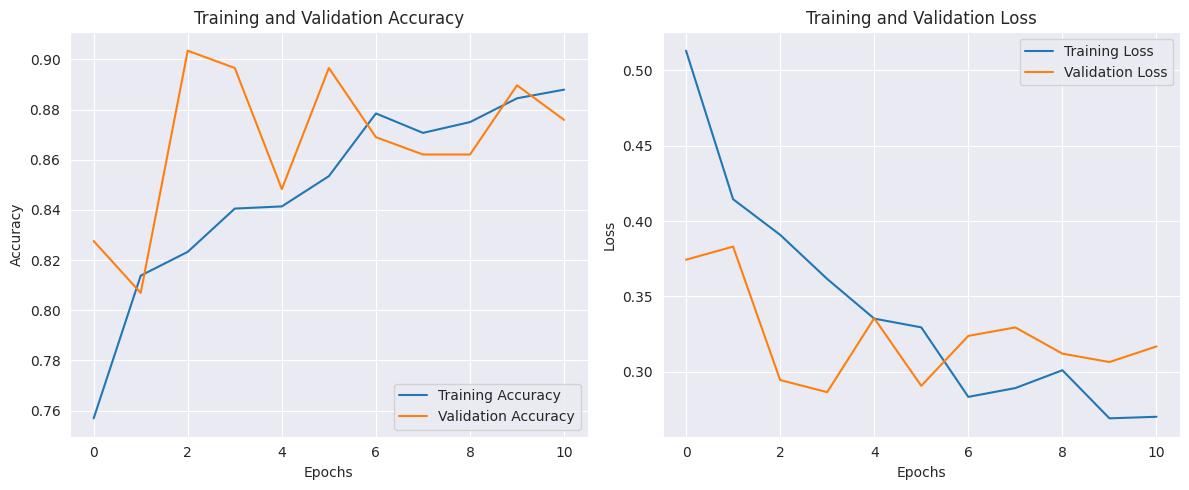

In [ ]:
# Cek ketersediaan metrik
print(history.history.keys())

# Visualisasi
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 447ms/step


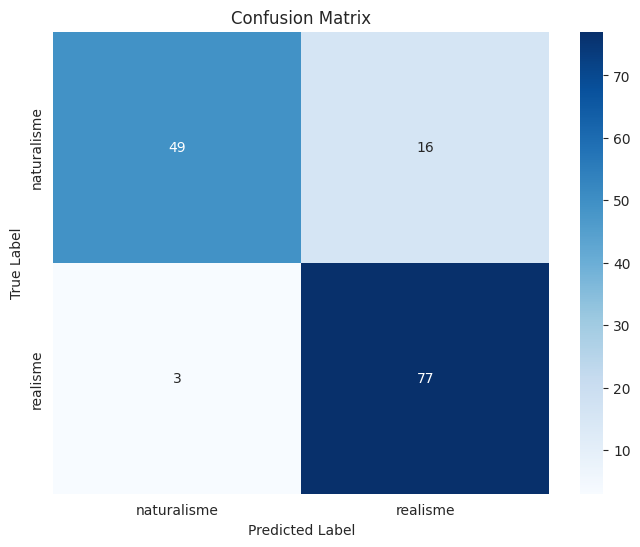

Classification Report:
              precision    recall  f1-score   support

 naturalisme       0.94      0.75      0.84        65
    realisme       0.83      0.96      0.89        80

    accuracy                           0.87       145
   macro avg       0.89      0.86      0.86       145
weighted avg       0.88      0.87      0.87       145



In [ ]:
# Prediksi kelas
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()  # Untuk binary classification
y_true = test_generator.classes

# Ambil nama kelas dari generator
class_names = list(test_generator.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

## Test Model

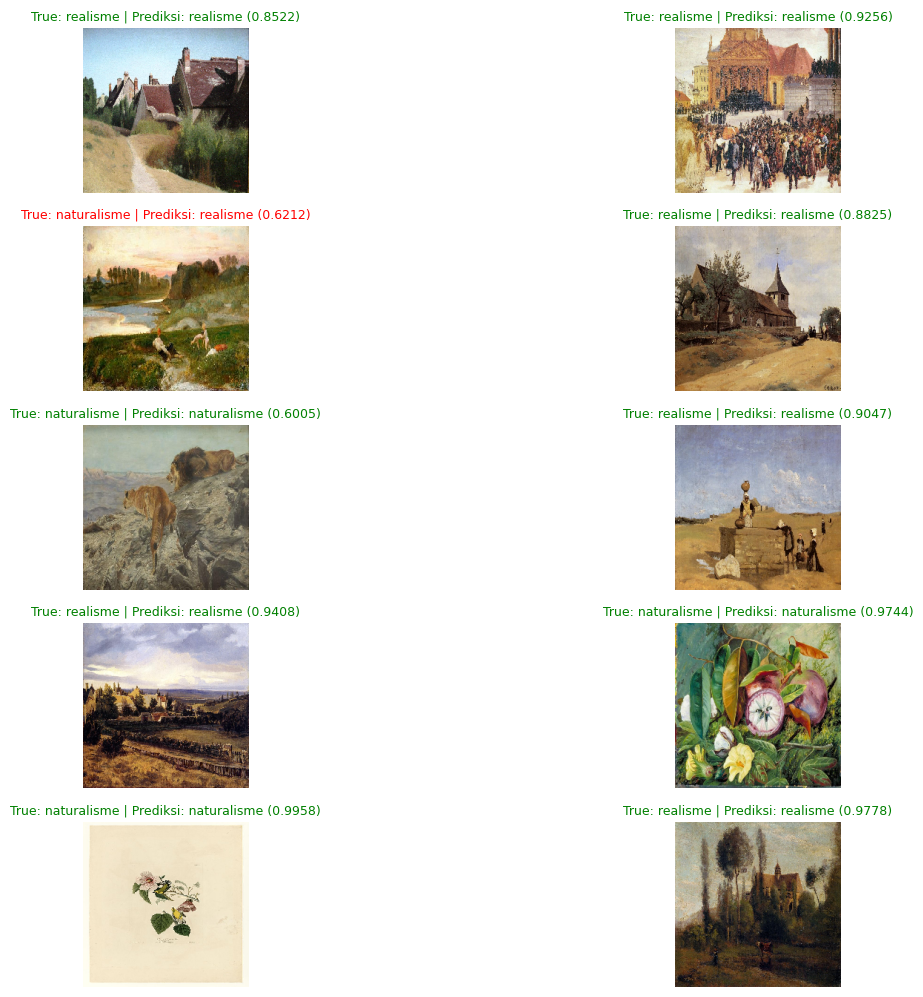

In [ ]:
# Muat model
model = load_model('best_model.h5')

def show_predictions(model, generator, class_names, jumlah=10):

    # Ambil indeks acak dari data test
    random_indices = np.random.choice(len(generator.filenames), jumlah, replace=False)

    plt.figure(figsize=(12, jumlah * 2))

    for i, idx in enumerate(random_indices):
        # Ambil path gambar dan label asli
        img_path = generator.filepaths[idx]
        true_label = generator.labels[idx]

        # Preprocessing gambar
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Prediksi
        prediction = model.predict(img_array, verbose=0)
        predicted_class = 1 if prediction > 0.5 else 0
        predicted_label = class_names[predicted_class]
        confidence = prediction[0][0] if predicted_class == 1 else 1 - prediction[0][0]

        # Warna judul (hijau = benar, merah = salah)
        color = 'green' if predicted_class == true_label else 'red'

        # Tampilkan gambar
        plt.subplot(jumlah, 2, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(
            f"True: {class_names[true_label]} | "
            f"Prediksi: {predicted_label} ({confidence:.4f})",
            color=color,
            fontsize=9
        )

    plt.tight_layout()
    plt.show()

# Ambil class_names dari test_generator
class_names = list(test_generator.class_indices.keys())

# Jalankan prediksi
show_predictions(model, test_generator, class_names, jumlah=10)

Saving images.jpg to images.jpg

--- Prediksi untuk: images.jpg ---


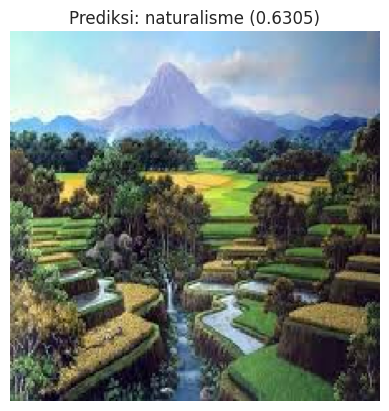

In [ ]:
# Load model
model = load_model('best_model.h5')

# Mapping label
label_map = {'naturalisme': 0, 'realisme': 1}  # Atau bisa: test_generator.class_indices
class_names = list(label_map.keys())

# Fungsi untuk prediksi gambar
def predict_image(img_path):
    # Muat dan ubah ukuran gambar
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0  # Normalisasi
    img_array = np.expand_dims(img_array, axis=0)  # Batch dimensi

    # Prediksi
    prediction = model.predict(img_array, verbose=0)[0][0]
    predicted_class = 1 if prediction > 0.5 else 0
    confidence = prediction if predicted_class == 1 else 1 - prediction

    # Tampilkan gambar dan prediksi
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediksi: {class_names[predicted_class]} ({confidence:.4f})")
    plt.show()

# Upload gambar
uploaded = files.upload()

# Prediksi gambar yang diunggah
for filename in uploaded.keys():
    print(f"\n--- Prediksi untuk: {filename} ---")
    predict_image(filename)

## Fine Tuning

In [ ]:
# Membersihkan sesi sebelumnya
tf.keras.backend.clear_session()

# Load model terbaik
model_fine_tune = load_model('best_model.h5')

# Ambil base model (layer ke-0)
base_model = model_fine_tune.layers[0]

# Unfreeze semua layer
base_model.trainable = True

# Freeze 100 layer pertama
for layer in base_model.layers[:100]:
    layer.trainable = False

# Kompilasi ulang dengan learning rate kecil
model_fine_tune.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Ringkasan model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,083 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 2 (12.00 B)

In [ ]:
# Callback untuk fine-tuning
fine_tune_callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
    ModelCheckpoint('fine_tuned_model.h5', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
]

# Fine-tuning model
fine_tune_history = model_fine_tune.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=fine_tune_callbacks
)

Epoch 1/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.7894 - loss: 0.4206
Epoch 1: val_loss improved from inf to 0.28543, saving model to fine_tuned_model.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 72s 644ms/step - accuracy: 0.7896 - loss: 0.4203 - val_accuracy: 0.8897 - val_loss: 0.2854 - learning_rate: 1.0000e-05
Epoch 2/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.8296 - loss: 0.3955
Epoch 2: val_loss did not improve from 0.28543
73/73 ━━━━━━━━━━━━━━━━━━━━ 32s 438ms/step - accuracy: 0.8295 - loss: 0.3954 - val_accuracy: 0.8759 - val_loss: 0.2865 - learning_rate: 1.0000e-05
Epoch 3/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.8516 - loss: 0.3730
Epoch 3: val_loss improved from 0.28543 to 0.28329, saving model to fine_tuned_model.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 43s 471ms/step - accuracy: 0.8517 - loss: 0.3728 - val_accuracy: 0.8828 - val_loss: 0.2833 - learning_rate: 1.0000e-05
Epoch 4/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.8654 - loss: 0.3236
Epoch 4: val_loss improved from 0.28329 to 0.27934, saving model to fine_tuned_model.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 33s 444ms/step - accuracy: 0.8651 - loss: 0.3240 - val_accuracy: 0.8759 - val_loss: 0.2793 - learning_rate: 1.0000e-05
Epoch 5/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.8186 - loss: 0.3643
Epoch 5: val_loss improved from 0.27934 to 0.27664, saving model to fine_tuned_model.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 32s 439ms/step - accuracy: 0.8188 - loss: 0.3641 - val_accuracy: 0.9034 - val_loss: 0.2766 - learning_rate: 1.0000e-05
Epoch 6/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.8574 - loss: 0.3403
Epoch 6: val_loss improved from 0.27664 to 0.27223, saving model to fine_tuned_model.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.8574 - loss: 0.3401 - val_accuracy: 0.9034 - val_loss: 0.2722 - learning_rate: 1.0000e-05
Epoch 7/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.8499 - loss: 0.3123
Epoch 7: val_loss improved from 0.27223 to 0.26682, saving model to fine_tuned_model.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 32s 436ms/step - accuracy: 0.8500 - loss: 0.3125 - val_accuracy: 0.9172 - val_loss: 0.2668 - learning_rate: 1.0000e-05
Epoch 8/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.8634 - loss: 0.3333
Epoch 8: val_loss improved from 0.26682 to 0.25694, saving model to fine_tuned_model.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 33s 453ms/step - accuracy: 0.8634 - loss: 0.3332 - val_accuracy: 0.9241 - val_loss: 0.2569 - learning_rate: 1.0000e-05
Epoch 9/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.8618 - loss: 0.3080
Epoch 9: val_loss improved from 0.25694 to 0.25560, saving model to fine_tuned_model.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 40s 447ms/step - accuracy: 0.8619 - loss: 0.3079 - val_accuracy: 0.9172 - val_loss: 0.2556 - learning_rate: 1.0000e-05
Epoch 10/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.8628 - loss: 0.3207
Epoch 10: val_loss did not improve from 0.25560
73/73 ━━━━━━━━━━━━━━━━━━━━ 32s 431ms/step - accuracy: 0.8630 - loss: 0.3205 - val_accuracy: 0.9172 - val_loss: 0.2594 - learning_rate: 1.0000e-05
Epoch 11/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.8739 - loss: 0.2946
Epoch 11: val_loss did not improve from 0.25560
73/73 ━━━━━━━━━━━━━━━━━━━━ 31s 426ms/step - accuracy: 0.8740 - loss: 0.2943 - val_accuracy: 0.9172 - val_loss: 0.2598 - learning_rate: 1.0000e-05
Epoch 12/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.8638 - loss: 0.2924
Epoch 12: val_loss improved from 0.25560 to 0.25506, saving model to fine_tuned_model.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 35s 479ms/step - accuracy: 0.8640 - loss: 0.2923 - val_accuracy: 0.9172 - val_loss: 0.2551 - learning_rate: 1.0000e-05
Epoch 13/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.8597 - loss: 0.2918
Epoch 13: val_loss improved from 0.25506 to 0.25457, saving model to fine_tuned_model.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 39s 456ms/step - accuracy: 0.8600 - loss: 0.2914 - val_accuracy: 0.9241 - val_loss: 0.2546 - learning_rate: 1.0000e-05
Epoch 14/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.8910 - loss: 0.2635
Epoch 14: val_loss improved from 0.25457 to 0.24536, saving model to fine_tuned_model.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.8910 - loss: 0.2635 - val_accuracy: 0.9241 - val_loss: 0.2454 - learning_rate: 1.0000e-05
Epoch 15/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.9074 - loss: 0.2316
Epoch 15: val_loss improved from 0.24536 to 0.23851, saving model to fine_tuned_model.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 32s 431ms/step - accuracy: 0.9073 - loss: 0.2316 - val_accuracy: 0.9310 - val_loss: 0.2385 - learning_rate: 1.0000e-05
Epoch 16/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.9060 - loss: 0.2236
Epoch 16: val_loss did not improve from 0.23851
73/73 ━━━━━━━━━━━━━━━━━━━━ 31s 429ms/step - accuracy: 0.9059 - loss: 0.2236 - val_accuracy: 0.9241 - val_loss: 0.2428 - learning_rate: 1.0000e-05
Epoch 17/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.8901 - loss: 0.2533
Epoch 17: val_loss improved from 0.23851 to 0.23720, saving model to fine_tuned_model.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 35s 472ms/step - accuracy: 0.8902 - loss: 0.2531 - val_accuracy: 0.9241 - val_loss: 0.2372 - learning_rate: 1.0000e-05
Epoch 18/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.9099 - loss: 0.2180
Epoch 18: val_loss improved from 0.23720 to 0.23540, saving model to fine_tuned_model.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 31s 426ms/step - accuracy: 0.9099 - loss: 0.2182 - val_accuracy: 0.9241 - val_loss: 0.2354 - learning_rate: 1.0000e-05
Epoch 19/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.9250 - loss: 0.2010
Epoch 19: val_loss improved from 0.23540 to 0.23143, saving model to fine_tuned_model.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 32s 437ms/step - accuracy: 0.9251 - loss: 0.2009 - val_accuracy: 0.9241 - val_loss: 0.2314 - learning_rate: 1.0000e-05
Epoch 20/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.9054 - loss: 0.2183
Epoch 20: val_loss improved from 0.23143 to 0.22375, saving model to fine_tuned_model.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 32s 429ms/step - accuracy: 0.9056 - loss: 0.2181 - val_accuracy: 0.9241 - val_loss: 0.2237 - learning_rate: 1.0000e-05
Epoch 21/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.9247 - loss: 0.1992
Epoch 21: val_loss improved from 0.22375 to 0.22018, saving model to fine_tuned_model.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 33s 446ms/step - accuracy: 0.9247 - loss: 0.1991 - val_accuracy: 0.9310 - val_loss: 0.2202 - learning_rate: 1.0000e-05
Epoch 22/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9117 - loss: 0.2089
Epoch 22: val_loss improved from 0.22018 to 0.21963, saving model to fine_tuned_model.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 32s 433ms/step - accuracy: 0.9117 - loss: 0.2089 - val_accuracy: 0.9172 - val_loss: 0.2196 - learning_rate: 1.0000e-05
Epoch 23/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.9261 - loss: 0.1869
Epoch 23: val_loss did not improve from 0.21963
73/73 ━━━━━━━━━━━━━━━━━━━━ 42s 447ms/step - accuracy: 0.9261 - loss: 0.1869 - val_accuracy: 0.9241 - val_loss: 0.2215 - learning_rate: 1.0000e-05
Epoch 24/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.9058 - loss: 0.2216
Epoch 24: val_loss did not improve from 0.21963
73/73 ━━━━━━━━━━━━━━━━━━━━ 32s 437ms/step - accuracy: 0.9061 - loss: 0.2211 - val_accuracy: 0.9241 - val_loss: 0.2270 - learning_rate: 1.0000e-05
Epoch 25/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.9218 - loss: 0.1857
Epoch 25: val_loss did not improve from 0.21963

Epoch 25: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
73/73 ━━━━━━━━━━━━━━━━━━━━ 40s 426ms/step - accuracy: 0.9219 - loss: 0.1858 - 

In [ ]:
# Evaluasi pada data train
train_loss, train_acc = model_fine_tune.evaluate(
    train_generator,
    steps=len(train_generator),
    verbose=1
)
print(f"\n Evaluasi Training Set")
print(f" Akurasi : {train_acc * 100:.2f}%")
print(f" Loss    : {train_loss:.4f}")

# Evaluasi pada data test
test_loss, test_acc = model_fine_tune.evaluate(
    test_generator,
    steps=len(test_generator),
    verbose=1
)
print(f"\n Evaluasi Testing Set")
print(f" Akurasi : {test_acc * 100:.2f}%")
print(f" Loss    : {test_loss:.4f}")

73/73 ━━━━━━━━━━━━━━━━━━━━ 32s 436ms/step - accuracy: 0.9617 - loss: 0.1311

Akurasi Training Set: 95.78% | Loss: 0.1311
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.9221 - loss: 0.1856
Akurasi Testing Set: 92.41% | Loss: 0.1964


 Metrik fine-tuning: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


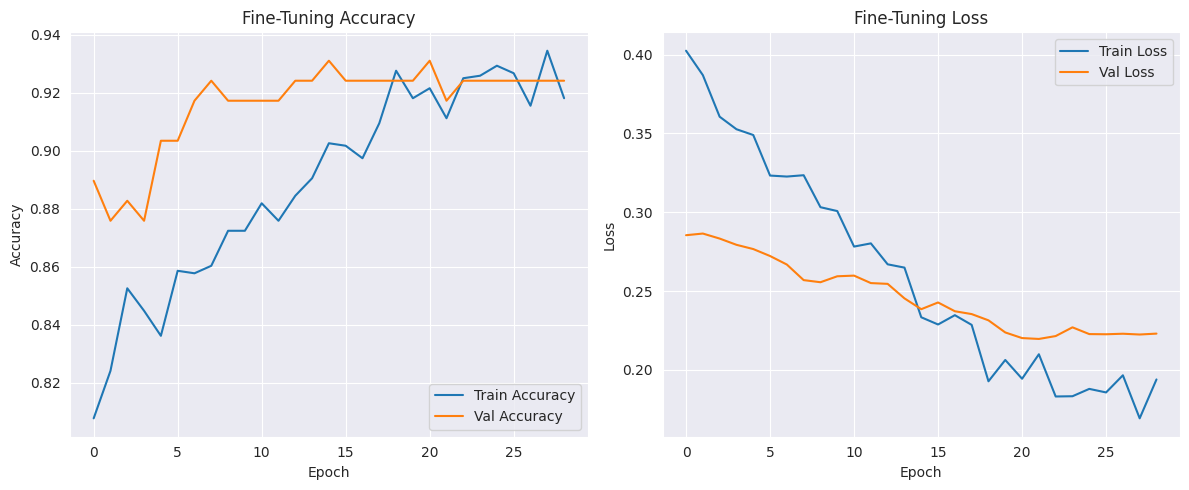

In [ ]:
# Cek ketersediaan metrik
print(fine_tune_history.history.keys())

# Visualisasi fine-tuning
ft_acc = fine_tune_history.history['accuracy']
ft_val_acc = fine_tune_history.history['val_accuracy']
ft_loss = fine_tune_history.history['loss']
ft_val_loss = fine_tune_history.history['val_loss']
ft_epochs_range = range(len(ft_acc))

plt.figure(figsize=(12, 5))

# Akurasi fine-tuning
plt.subplot(1, 2, 1)
plt.plot(ft_epochs_range, ft_acc, label='Training Accuracy')
plt.plot(ft_epochs_range, ft_val_acc, label='Validation Accuracy')
plt.title('Fine-Tuning Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Loss fine-tuning
plt.subplot(1, 2, 2)
plt.plot(ft_epochs_range, ft_loss, label='Training Loss')
plt.plot(ft_epochs_range, ft_val_loss, label='Validation Loss')
plt.title('Fine-Tuning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 425ms/step
Label Kelas: {'naturalisme': 0, 'realisme': 1}


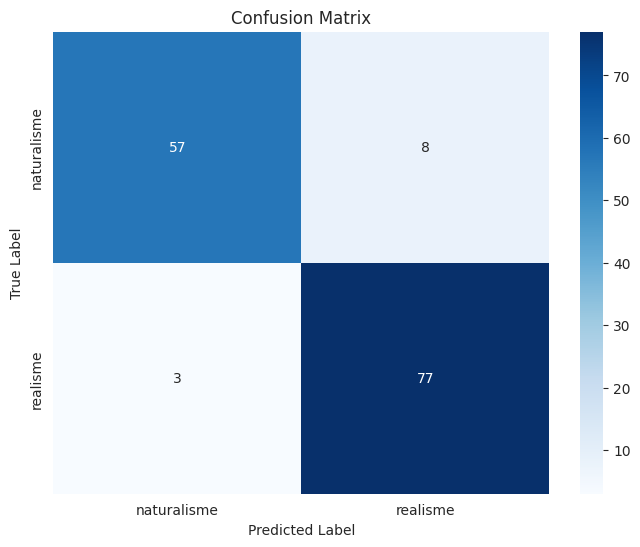

 Classification Report:
              precision    recall  f1-score   support

 naturalisme       0.95      0.88      0.91        65
    realisme       0.91      0.96      0.93        80

    accuracy                           0.92       145
   macro avg       0.93      0.92      0.92       145
weighted avg       0.93      0.92      0.92       145



In [ ]:
# Prediksi pada data test
y_pred = model_fine_tune.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Ambil nama kelas dari generator
class_names = list(test_generator.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification report
print(" Classification Report:")+
print(classification_report(y_true, y_pred_classes, target_names=class_names))

## Test Model Fine Tuning

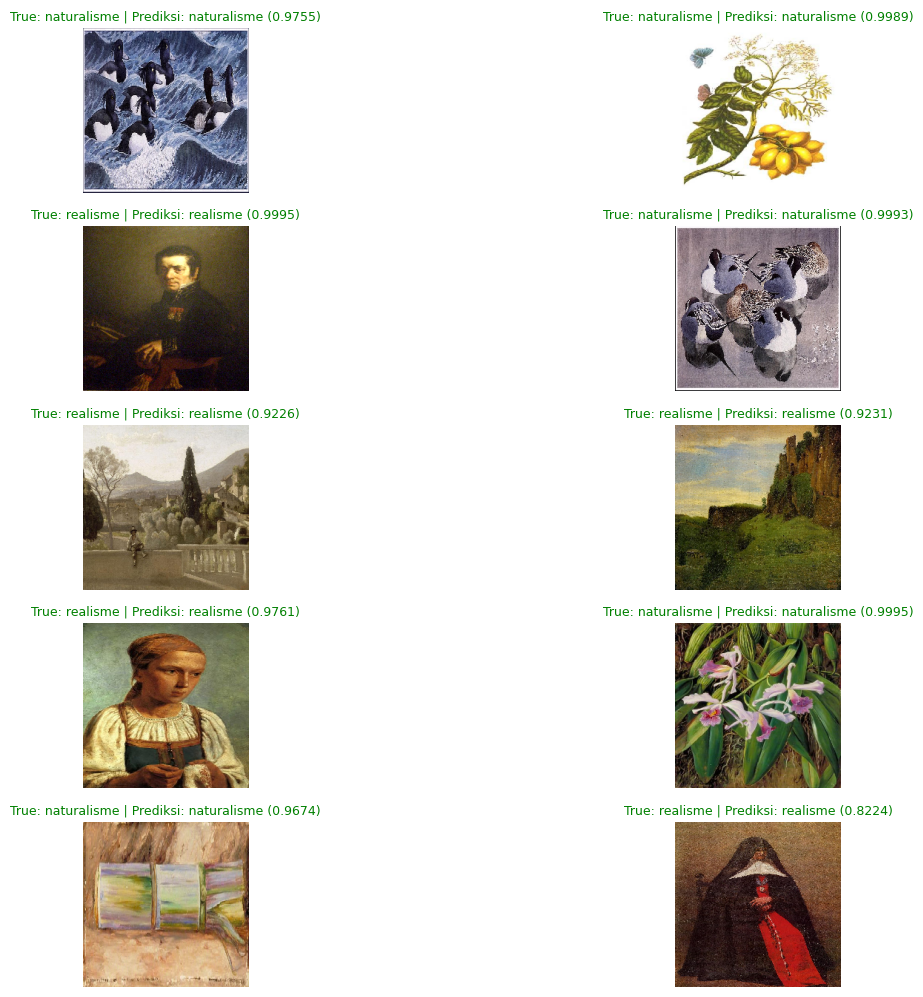

In [ ]:
# Load model hasil fine-tuning
model_fine_tune = load_model('fine_tuned_model.h5')

def show_predictions(model, generator, class_names, jumlah=10):

    # Ambil indeks acak dari data test
    random_indices = np.random.choice(len(generator.filenames), jumlah, replace=False)

    plt.figure(figsize=(12, jumlah * 2))

    for i, idx in enumerate(random_indices):
        # Ambil path gambar dan label asli
        img_path = generator.filepaths[idx]
        true_label = generator.labels[idx]

        # Preprocessing gambar
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Prediksi
        prediction = model.predict(img_array, verbose=0)
        predicted_class = 1 if prediction > 0.5 else 0
        predicted_label = class_names[predicted_class]
        confidence = prediction[0][0] if predicted_class == 1 else 1 - prediction[0][0]

        # Warna judul (hijau = benar, merah = salah)
        color = 'green' if predicted_class == true_label else 'red'

        # Tampilkan gambar
        plt.subplot(jumlah, 2, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(
            f"True: {class_names[true_label]} | "
            f"Prediksi: {predicted_label} ({confidence:.4f})",
            color=color,
            fontsize=9
        )

    plt.tight_layout()
    plt.show()

# Ambil class_names dari test_generator
class_names = list(test_generator.class_indices.keys())

# Jalankan prediksi
show_predictions(model_fine_tune, test_generator, class_names, jumlah=10)

Saving lukisan-naturalisme-1_169.jpeg to lukisan-naturalisme-1_169.jpeg

--- Prediksi untuk: lukisan-naturalisme-1_169.jpeg ---


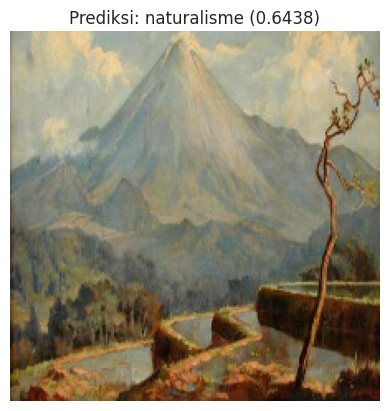

In [ ]:
# Load model hasil fine-tuning
model = load_model('fine_tuned_model.h5')

# Mapping label
label_map = {'naturalisme': 0, 'realisme': 1}  # Atau bisa: test_generator.class_indices
class_names = list(label_map.keys())

# Fungsi untuk prediksi gambar
def predict_image(img_path):
    # Muat dan ubah ukuran gambar
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0  # Normalisasi
    img_array = np.expand_dims(img_array, axis=0)  # Batch dimensi

    # Prediksi
    prediction = model.predict(img_array, verbose=0)[0][0]
    predicted_class = 1 if prediction > 0.5 else 0
    confidence = prediction if predicted_class == 1 else 1 - prediction

    # Tampilkan gambar dan prediksi
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediksi: {class_names[predicted_class]} ({confidence:.4f})")
    plt.show()

# Upload gambar
uploaded = files.upload()

# Prediksi semua gambar yang diunggah
for filename in uploaded.keys():
    print(f"\n--- Prediksi untuk: {filename} ---")
    predict_image(filename)